In [43]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math

In [44]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './final_out'

In [45]:
train_settings = {
    "Baseline_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": None, "factor": 1},
    "combined_1": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 2., 1.5]]},
    "combined_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 2., 2.]]},
    "combined_1": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 3., 4.]]},
    "combined_2": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 4., 6.]]},
    "combined_5": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 4., 6., 8.]]},
    "combined_6": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 4., 6., 8.]]},
    "combined_3": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 2., 4., 8.]]},
    "combined_8": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 8., 8., 8., 8.]]},
    "combined_9": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": ["distribution", "follow_leader"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 4., 4., 4., 4.]]},
    "combined_11": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2., 4., 6., 8., 2]]},
    "combined_4": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2/1.5, 4., 6., 8., 1.5]]},
    "combined_7": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2/1.6, 4., 6., 8., 1.6]]},
    "combined_10": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2/1.7, 4., 6., 8., 1.7]]},
    "combined_13": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2/1.2, 4., 6., 8., 1.2]]},
    "combined_12": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2, 4., 6., 8., 1.]]},
    "combined_14": {"epochs": 4, "lr": 0.005, "l2": None, "loss_type": ["distribution", "follow_leader_v2"], 
                                                          "factor": [[15, 20, 15, 15, 20], [0, 2/0.8, 4., 6., 8., 0.8]]},
}


## Dataloader

In [46]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [47]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [48]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [49]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [50]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

In [51]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [52]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train

In [53]:
def train(model, task_num, criterion, prev_model, epoches = 4, lr = 0.001, l2 = None, loss_type = None, factor = 1):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    if l2 is None:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr)
    else:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr, weight_decay = l2)
        
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}

    if(loss_type):
        if (isinstance(factor[0], int) or isinstance(factor[0], float) ):
            distribution_factor = factor[0]
        else:
            distribution_factor = factor[0][task_num]
        
        if (isinstance(factor[1], int) or isinstance(factor[1], float) ):
            follow_leader_factor = factor[1]
        else:
            follow_leader_factor = factor[1][task_num]

    if(task_num!= 0):
        alpha = factor[1][-1]
        leading_factor = follow_leader_factor / task_num * alpha
        if(task_num!= 1):
            sub_leading_factor = (follow_leader_factor - leading_factor) / (task_num - 1)
        else:
            sub_leading_factor = 0

        print(f"leading_factor {leading_factor:.3f}, sub_leading_factor {sub_leading_factor:.3f}")
    
    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            reg_loss = 0
            if (loss_type and "distribution" in loss_type):
                random_data = torch.rand(256, 1, 28, 28).to(device)
                random_data = (random_data - 0.5) / 0.5
                random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
                fake_output = follower(random_data)
                reg_loss += distribution_factor * criterion(fake_output, random_target)
            if (loss_type and "follow_leader" in loss_type):
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    reg_loss += follow_leader_factor / task_num * torch.mean(torch.abs(leader_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]))
            if (loss_type and "follow_leader_v2" in loss_type):
                for k, mod in enumerate(prev_model):
                    with torch.no_grad():
                        leader_output = mod(images)
                    diff = torch.mean(torch.abs(leader_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]))

                    if (k == task_num - 1):
                        reg_loss += leading_factor * diff
                    else:
                        reg_loss += sub_leading_factor * diff
                    
            loss = criterion(outputs[:,:valid_out_dim], labels) + reg_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            batch_num += 1

        adjust_learning_rate(optimizer_F)

        avg_acc = 0
        log_message = []
        log_message.append(f"Epoch: {e}, ")
        for task in range(task_num + 1):
            acc = cal_acc(follower, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            log_message.append(f"Task {task} acc: {acc * 100:.4f}")

        logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
    
    return follower, task_accuracies

In [54]:
def setup_logging(task_name, epochs, lr, factor, l2):
    log_filename = f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log"
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(log_filename),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    print(f"Training on {task_name}")
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    settings = train_settings[task_name]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']


    if os.path.exists(f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log") == False:
        setup_logging(task_name, epochs, lr, factor, l2)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            model, task_accuracies = train(model, task, criterion, prev_model, epoches = epochs, lr = lr, l2 = l2, loss_type = loss_type, factor = factor)
            all_accuracies.append(task_accuracies)
            prev_model.append(model)
        
        

        plot_task_acc_history(all_accuracies, f"{output_dir}/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png", epochs)

Training on Baseline_0
Training on combined_1
Training on combined_0
Training on combined_2
Training on combined_5
Training on combined_6
Training on combined_3
Training on combined_8
Training on combined_9
Training on combined_11
Training on combined_4
Training on combined_7
Training on combined_10
Training on combined_13

2024-05-31 07:22:05,467 - INFO - ##########Task 0##########
2024-05-31 07:22:05,468 - INFO - Epoch 0



Training on combined_12
Training on combined_14


2024-05-31 07:22:11,163 - INFO - Epoch: 0, , Task 0 acc: 95.9184, Task avg acc:95.9184
2024-05-31 07:22:11,164 - INFO - Epoch 1
2024-05-31 07:22:16,004 - INFO - Epoch: 1, , Task 0 acc: 98.9716, Task avg acc:98.9716
2024-05-31 07:22:16,005 - INFO - Epoch 2
2024-05-31 07:22:20,956 - INFO - Epoch: 2, , Task 0 acc: 97.1381, Task avg acc:97.1381
2024-05-31 07:22:20,957 - INFO - Epoch 3
2024-05-31 07:22:25,806 - INFO - Epoch: 3, , Task 0 acc: 96.1416, Task avg acc:96.1416
2024-05-31 07:22:25,817 - INFO - ##########Task 1##########
2024-05-31 07:22:25,818 - INFO - Epoch 0


leading_factor 2.000, sub_leading_factor 0.000


2024-05-31 07:22:32,738 - INFO - Epoch: 0, , Task 0 acc: 52.1843, Task 1 acc: 77.7926, Task avg acc:64.9884
2024-05-31 07:22:32,738 - INFO - Epoch 1
2024-05-31 07:22:39,619 - INFO - Epoch: 1, , Task 0 acc: 52.9895, Task 1 acc: 79.0392, Task avg acc:66.0144
2024-05-31 07:22:39,621 - INFO - Epoch 2
2024-05-31 07:22:46,483 - INFO - Epoch: 2, , Task 0 acc: 53.6591, Task 1 acc: 78.5821, Task avg acc:66.1206
2024-05-31 07:22:46,483 - INFO - Epoch 3
2024-05-31 07:22:53,451 - INFO - Epoch: 3, , Task 0 acc: 56.5768, Task 1 acc: 82.1476, Task avg acc:69.3622
2024-05-31 07:22:53,462 - INFO - ##########Task 2##########
2024-05-31 07:22:53,465 - INFO - Epoch 0


leading_factor 1.600, sub_leading_factor 2.400


2024-05-31 07:23:02,111 - INFO - Epoch: 0, , Task 0 acc: 62.3884, Task 1 acc: 15.5502, Task 2 acc: 47.9436, Task avg acc:41.9607
2024-05-31 07:23:02,111 - INFO - Epoch 1
2024-05-31 07:23:11,420 - INFO - Epoch: 1, , Task 0 acc: 68.5029, Task 1 acc: 21.7005, Task 2 acc: 29.4630, Task avg acc:39.8888
2024-05-31 07:23:11,422 - INFO - Epoch 2
2024-05-31 07:23:20,365 - INFO - Epoch: 2, , Task 0 acc: 70.8626, Task 1 acc: 9.1922, Task 2 acc: 30.5226, Task avg acc:36.8591
2024-05-31 07:23:20,366 - INFO - Epoch 3
2024-05-31 07:23:29,194 - INFO - Epoch: 3, , Task 0 acc: 59.8374, Task 1 acc: 5.2111, Task 2 acc: 38.6584, Task avg acc:34.5690
2024-05-31 07:23:29,206 - INFO - ##########Task 3##########
2024-05-31 07:23:29,207 - INFO - Epoch 0


leading_factor 1.600, sub_leading_factor 2.200


2024-05-31 07:23:40,366 - INFO - Epoch: 0, , Task 0 acc: 77.2321, Task 1 acc: 18.3511, Task 2 acc: 1.2841, Task 3 acc: 46.5625, Task avg acc:35.8575
2024-05-31 07:23:40,367 - INFO - Epoch 1
2024-05-31 07:23:51,706 - INFO - Epoch: 1, , Task 0 acc: 70.6792, Task 1 acc: 27.0445, Task 2 acc: 11.5302, Task 3 acc: 49.4655, Task avg acc:39.6798
2024-05-31 07:23:51,706 - INFO - Epoch 2
2024-05-31 07:24:02,963 - INFO - Epoch: 2, , Task 0 acc: 76.4748, Task 1 acc: 20.8361, Task 2 acc: 1.9127, Task 3 acc: 35.1480, Task avg acc:33.5929
2024-05-31 07:24:02,964 - INFO - Epoch 3
2024-05-31 07:24:14,075 - INFO - Epoch: 3, , Task 0 acc: 77.2800, Task 1 acc: 19.5479, Task 2 acc: 1.0506, Task 3 acc: 40.5674, Task avg acc:34.6115
2024-05-31 07:24:14,086 - INFO - ##########Task 4##########
2024-05-31 07:24:14,086 - INFO - Epoch 0


leading_factor 1.600, sub_leading_factor 2.133


2024-05-31 07:24:27,811 - INFO - Epoch: 0, , Task 0 acc: 60.6266, Task 1 acc: 26.4129, Task 2 acc: 1.9217, Task 3 acc: 0.0082, Task 4 acc: 45.5503, Task avg acc:26.9039
2024-05-31 07:24:27,812 - INFO - Epoch 1
2024-05-31 07:24:41,289 - INFO - Epoch: 1, , Task 0 acc: 59.7417, Task 1 acc: 30.8677, Task 2 acc: 1.7152, Task 3 acc: 1.1924, Task 4 acc: 42.7310, Task avg acc:27.2496
2024-05-31 07:24:41,290 - INFO - Epoch 2
2024-05-31 07:24:54,855 - INFO - Epoch: 2, , Task 0 acc: 62.0536, Task 1 acc: 40.7829, Task 2 acc: 2.1552, Task 3 acc: 0.3783, Task 4 acc: 40.8543, Task avg acc:29.2448
2024-05-31 07:24:54,856 - INFO - Epoch 3
2024-05-31 07:25:09,017 - INFO - Epoch: 3, , Task 0 acc: 65.8721, Task 1 acc: 41.2068, Task 2 acc: 2.2360, Task 3 acc: 0.9375, Task 4 acc: 32.9059, Task avg acc:28.6317


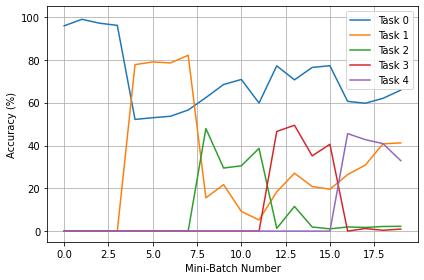

In [55]:
for key in train_settings.keys():
    train_split_task(key)

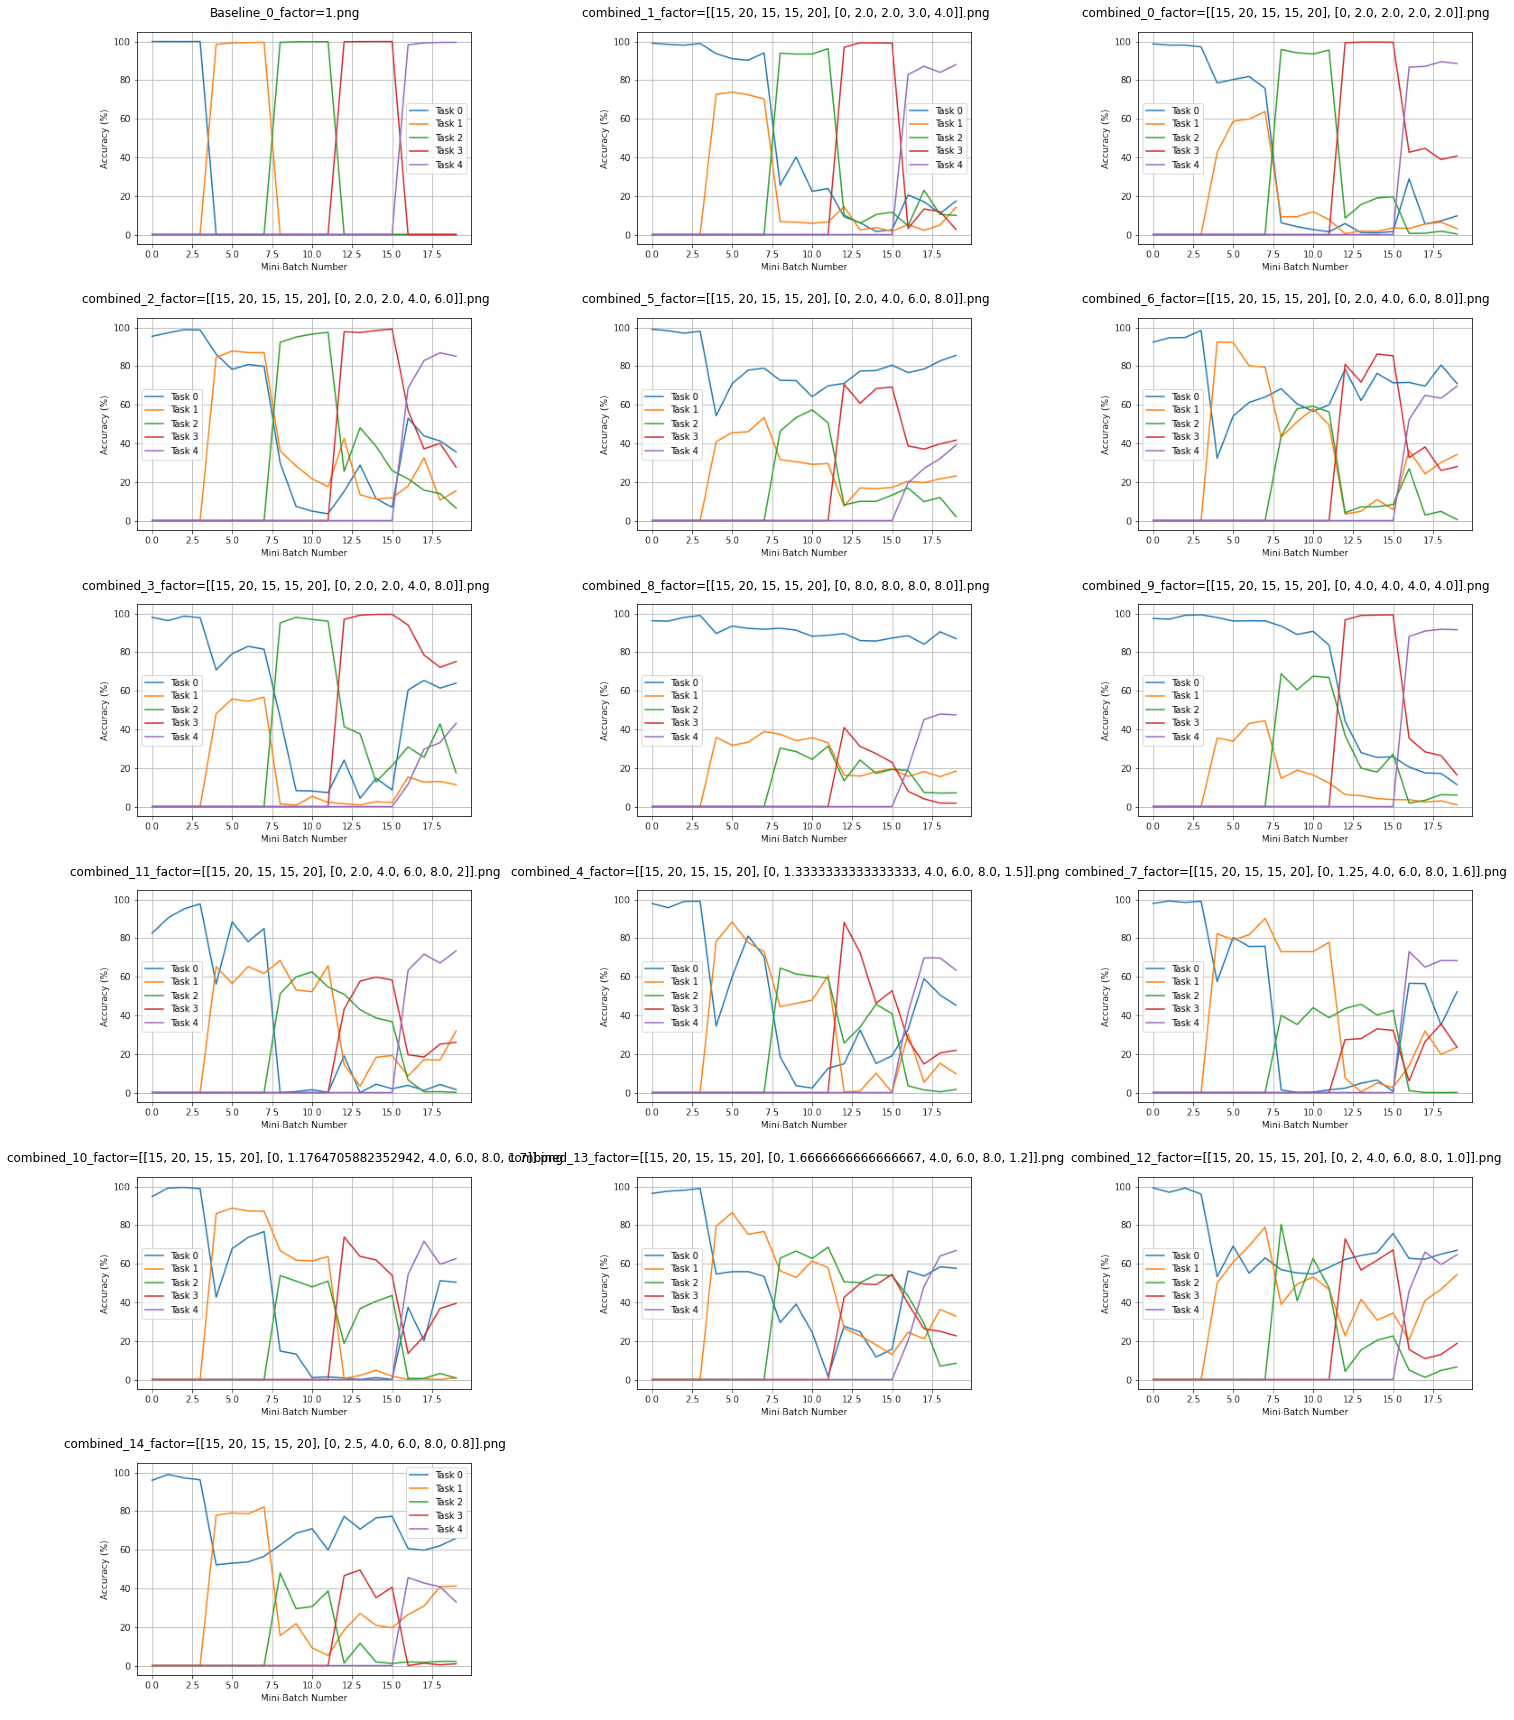

In [56]:
from PIL import Image
import matplotlib.pyplot as plt
import math

ncols = 3
nrows = math.ceil(len(train_settings.keys()) / 3.)

plt.figure(figsize=(21, 4 * nrows))  # Adjust the figure size based on the number of rows
for i, key in enumerate(train_settings.keys()):
    plt.subplot(nrows, ncols, i + 1)

    settings = train_settings[key]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']

    file_name = f"{output_dir}/{key}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png"
    try:
        with Image.open(file_name) as img:
            plt.imshow(img)
            plt.title(f"{key}_factor={factor}.png")
            plt.axis('off')
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist.")
plt.tight_layout()
plt.show()  # Move plt.show() outside the loop to display all subplots at once
